# Calibration of a line to data comparing approaches to dealing with systematic error

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## make the model

In [3]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [4]:
my_model = LinearModel()

In [5]:
rng = np.random.default_rng(13)

## set up prior

In [6]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.3),
        ("b", 1),
    ]
)

In [7]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [8]:
n_prior_samples = 1000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples, random_state=rng)

In [9]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

In [10]:
systematic_fractional_err = 0.00
# choose a normalization 1 std deviation below the mean
N = 1 - systematic_fractional_err
noise = 0.05
x = np.linspace(0.01, 1.0, 10, dtype=float)
y_stat_err = noise * np.ones_like(x) * N  # noise is just a constant fraction of y
y_true = my_model.y(x, *list(true_params.values()))
y_exp = (y_true + rng.normal(scale=noise, size=len(x))) * N

Text(0.5, 1.0, 'experimental constraint with bias')

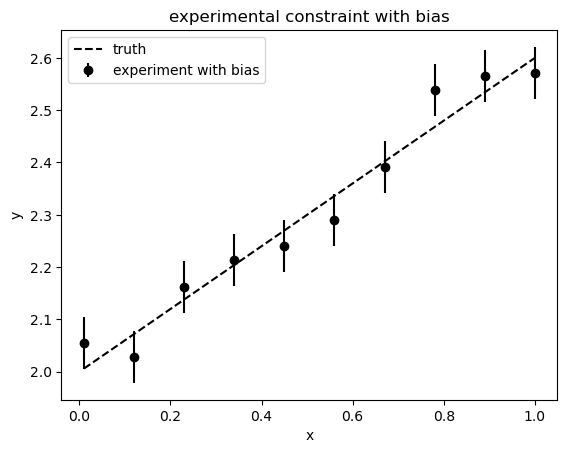

In [11]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

## Compare Likelihood Models
We will look at a few different cases:
1. Covariance is fixed to just statistical error (disregarding systematic error)

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2
   \end{equation}

3. Covariance is just statistical error, but we fit the magnitude of the statistical noise $\eta$ (disregarding systematic error). This means the covariance is not fixed, but will be updated during calibration.

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \eta^2
   \end{equation}


5. Systematic error is included properly in covariance, making the covariance a function of the model prediction. Again, this means the covariance is not fixed, but will be updated during calibration.

    \begin{equation}
       \Sigma_{ij}(\alpha) = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y_m(x_i; \alpha) y_m(x_j; \alpha)
   \end{equation}

7. Systematic error is included improperly in covariance, using the experimental $y(x_i)$ instead of the model prediction $y_m(x_i;\alpha)$. In this case the covariance is again fixed.

    \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y(x_i) y(x_j)
   \end{equation}


In [12]:
# 1 and 2
obs_stat_only = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
    y_sys_err_normalization=systematic_fractional_err,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp, y_exp),
)

## set up likelihood models and constraints

In [13]:
# 1, 3 and 4
likelihood = rxmc.likelihood_model.LikelihoodModel()

# 2 - a special likelihood model that takes in the noise fraction as a parameter
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [14]:
# 1
corpus_stat_only = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood,
        )
    ]
)

# 2
corpus_unknown_stat = rxmc.corpus.Corpus(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
corpus_sys_correct = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct],
            my_model,
            likelihood,
        )
    ]
)

# 4
corpus_sys_wrong = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong],
            my_model,
            likelihood,
        )
    ]
)

In [15]:
def proposal_distribution_model(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 1000, random_state=rng
    )

In [16]:
my_model_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model,
    prior=prior_distribution,
)

## Run option 1: fixed covariance, statistical error only

In [17]:
walker1 = rxmc.walker.Walker(
    my_model_sampling_config,
    corpus_stat_only,
    rng=rng,
)

In [18]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.489
CPU times: user 3.28 s, sys: 490 ms, total: 3.77 s
Wall time: 3.23 s


0.4886

Text(0.5, 0, '$i$')

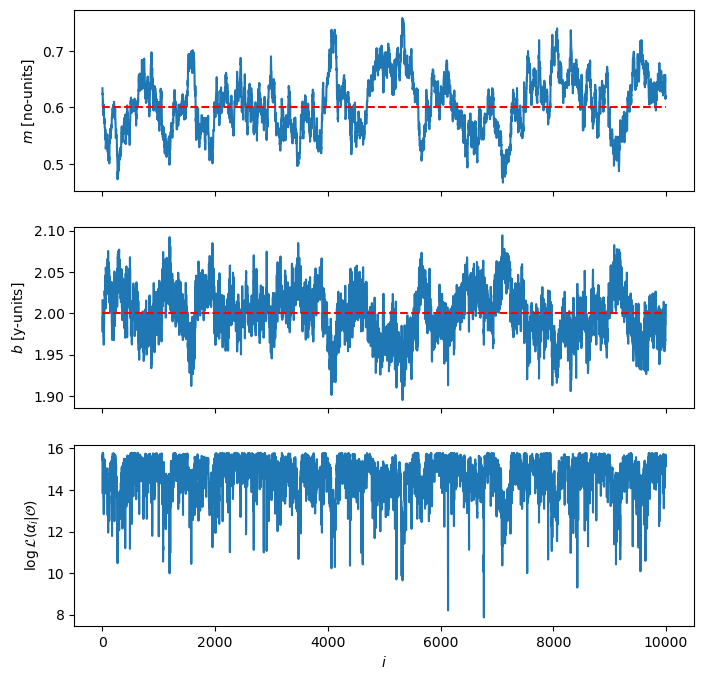

In [19]:
fig, axes = plt.subplots(
    walker1.model_chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
)
for i in range(walker1.model_chain.shape[1]):
    axes[i].plot(walker1.model_chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(walker1.model_chain), "r", linestyle="--")


axes[-1].plot(walker1.log_posterior_record)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [20]:
posterior_range = np.vstack(
    [np.min(walker1.model_chain, axis=0), np.max(walker1.model_chain, axis=0)]
).T

Text(0.5, 0.98, 'posterior')

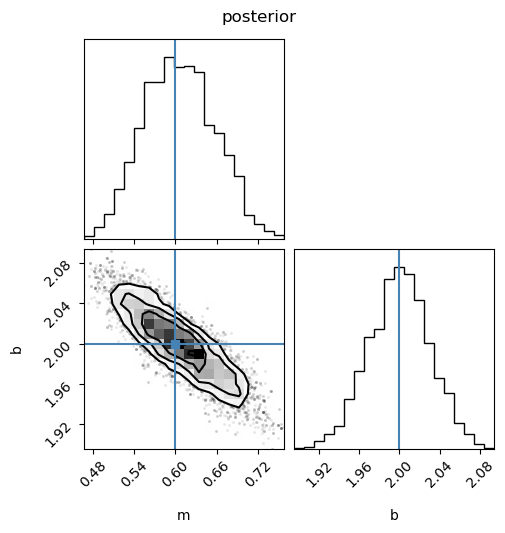

In [21]:
fig = corner.corner(
    walker1.model_chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [22]:
n_posterior_samples = walker1.model_chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = walker1.model_chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'statistical error only')

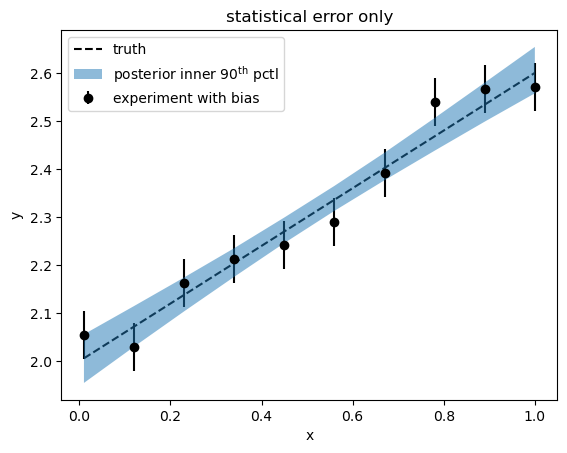

In [23]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("statistical error only")

## Run option 2: unknown statistical error

We need to come up with a prior for the noise for option 2. We will keep it fairly wide and centered about the reported value.

In [24]:
noise_prior = stats.norm(loc=0.05, scale=0.0005)

In [25]:
def proposal_distribution_noise(noise_frac):
    return stats.norm.rvs(loc=noise_frac, scale=0.0001)

In [26]:
noise_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=likelihood_unknown_stat.params,
    starting_location=noise_prior.mean(),
    proposal=proposal_distribution_noise,
    prior=noise_prior,
)

In [27]:
def proposal_distribution_model_unknown_stat(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [28]:
model_sampling_config2 = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model_unknown_stat,
    prior=prior_distribution,
)

In [29]:
walker2 = rxmc.walker.Walker(
    model_sample_conf=model_sampling_config2,
    corpus=corpus_unknown_stat,
    likelihood_sample_confs=[noise_sampling_config],
    rng=rng,
)

In [30]:
%%time
walker2.walk(
    n_steps=100000,
    burnin=0,
    batch_size=500,
    verbose=False,
)

CPU times: user 53.1 s, sys: 90.4 ms, total: 53.2 s
Wall time: 53.1 s


(0.94991, [0.6988])

Text(0.5, 0, '$i$')

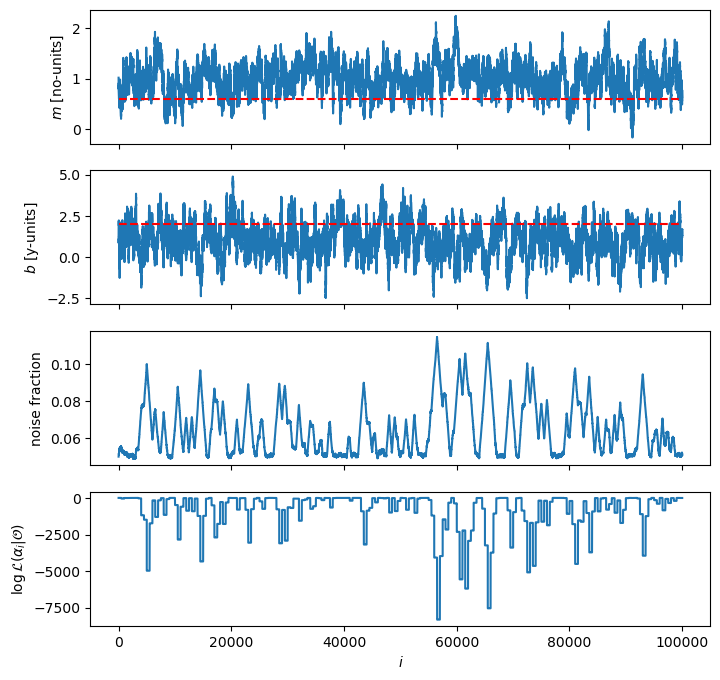

In [31]:
fig, axes = plt.subplots(
    walker2.model_chain.shape[1] + 2, 1, figsize=(8, 8), sharex=True
)
for i in range(walker2.model_chain.shape[1]):
    axes[i].plot(walker2.model_chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(walker2.model_chain), "r", linestyle="--")

axes[-2].plot(walker2.likelihood_chain[0])
axes[-2].set_ylabel(r"noise fraction")


axes[-1].plot(walker2.log_posterior_record)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [32]:
posterior_range = np.vstack(
    [np.min(walker2.model_chain, axis=0), np.max(walker2.model_chain, axis=0)]
).T

Text(0.5, 0.98, 'posterior')

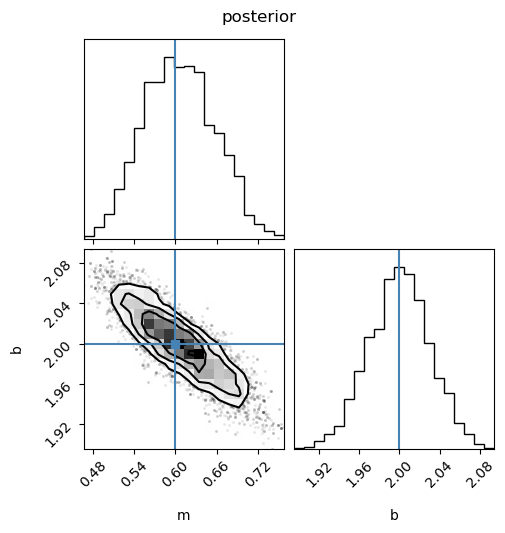

In [33]:
fig = corner.corner(
    walker1.model_chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [34]:
n_posterior_samples = walker2.model_chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = walker2.model_chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'statistical error only')

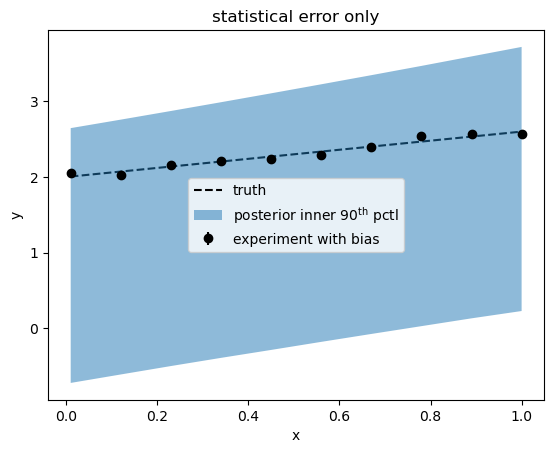

In [35]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("statistical error only")

## Run option 3: correct formulation of the systematic error

In [36]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_sys_correct]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

AttributeError: module 'rxmc.mcmc' has no attribute 'run_chain'

In [37]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

NameError: name 'chain' is not defined

In [ ]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [ ]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [ ]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Correct systematic error")

## run option 4: fixed covariance with wrong systematic error

In [ ]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_sys_wrong]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

In [ ]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [ ]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [ ]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [ ]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Incorrect systematic error")

# Multiple constraints
Let's add a second constraint and see how these Likelihood models compare.

In [ ]:
systematic_fractional_err2 = 0.07
# choose a normalization 1 std deviation above the mean
N2 = 1 + systematic_fractional_err2
noise2 = 0.05
x2 = np.linspace(0.7, 1.5, 30, dtype=float)
y_stat_err2 = noise2 * np.ones_like(x2) * N2  # noise is just a constant fraction of y
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise2, size=len(x2))) * N2

In [ ]:
fullx = np.linspace(0, 1.6, 10)
ytrue_full = my_model.y(fullx, *list(true_params.values()))

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="observation 1",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="observation 2",
)

plt.plot(fullx, ytrue_full, "k--", label="truth")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple constraint with normalization error")

In [ ]:
# 1 and 2
obs_stat_only2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2),
)

# 3
obs_sys_norm_correct2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)